In [64]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import unidecode
from bs4 import BeautifulSoup
from nltk import tokenize, download, ngrams, FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from statsmodels.stats.proportion import proportions_ztest

In [65]:
# Preprocess data
def prepocess_data(rest_file, review_file):
    """"
    A function that reads in the restaurant and review data .csvs, as provided by the notebook data_processing.ipynb

    Input: two file names: rest_file for restaurant information, and review_file for the review information
    Output: df, a combined dataframe of restaurant and review data for NLP analysis
    """
    
    # Read in restaurant, review data
    rest_data = pd.read_csv(rest_file, index_col=0)
    reviews = pd.read_csv(review_file, index_col=0)

    # Select columns of interest from restaurants
    rest_data = rest_data[['alias', 'price', 'is_michelin']]

    reviews = reviews[['eliteYear', 'localizedDate',
                    'rating', 'comment.text', 'restaurant']]

    # Rename for easy join
    reviews.rename(columns={'restaurant':'alias'}, inplace=True)

    # Merge dataframes
    df = pd.merge(reviews, rest_data, how='inner', on='alias')

    # Rename columns for ease
    df.columns = ['elite_year', 'review_date','rating','review',
                    'alias','price', 'michelin']
    
    # Return dataframe for analyis
    return df

In [66]:
# Preprocess the reviews for analysis
def preprocess_reviews(df):
    """
    A function that cleans the dataframe text for reviews

    Input: df, a processed dataframe
    Output: df, a processed dataframe with cleaned review text
    """

    # Drop duplicate reviews (use copy to avoid Pandas warning)
    df = df[df['review'].duplicated() == False].copy()

    # Drop no reviews
    df = df[df['review'].str.contains('[a-zA-Z]')]

    # Remove HTML tags from text using Beautiful Soup
    # Why a library over regular expressions? Better edge case handling
    df.loc[:, 'review'] = df['review'].apply(lambda x: unidecode.unidecode(BeautifulSoup(x, 'html.parser').get_text(separator=' '))) 
    # The warning just means maybe not all contain HTML tags, it's fine. Unidecode to remove non-English chars

    # Remove odd characters, rest seem plausible
    df.loc[:, 'review'] = df['review'].apply(lambda x: re.sub(r'[{}*\r\\\^#`|]', '', x)) # Hashtags don't work with VADER

    # Remove extra spaces
    df.loc[:, 'review'] = df['review'].apply(lambda x: re.sub(r'\s+', ' ', x))

    # Return cleaned dataframe
    return df

In [67]:
# Run VADER model for sentiment calculations
def run_vader(reviews, to_download = False, test_method = True):
    """
    A function that runs the VADER methodology by user selection to obtain sentiment calculations
    
    Input: reviews, or the Series containing review text; to_download, if the user needs to install
    NLTK dependencies; test method, if the user wants to see a comparison of performance using the averaging or non-averaging
    method of the VADER methodology
    Output: list of sentiment polarity values (each element is a review)
    """

    # If user needs dependencies, download them to run VADER
    if to_download:
        download('punkt')
        download('vader_lexicon')

    # Get a list for tracking sentiment of each review
    overall_sent = []

    # Get sentiment object
    sid = SentimentIntensityAnalyzer()

    # Get list of reviews
    review_list = list(reviews)

    # Tokenize each review on sentence level, get VADER output for each sentence and take the mean
    for rev in review_list:
        review = tokenize.sent_tokenize(rev)
        rev_sent = []
        # Now for each sentence, get the polarity
        for i in review:
            rev_sent.append(sid.polarity_scores(i)['compound'])
        
        # Stitch mean to list for final output
        overall_sent.append(np.array(rev_sent).mean())

    # If the user wants to compare methodologies, calculate and return both methods
    if test_method:
        rev_sent = []

        # For each sentence, apply VADER to the entire sentence
        for sentence in review_list:
            rev_sent.append(sid.polarity_scores(sentence)['compound'])

        # Return both
        return overall_sent, rev_sent
    
    # Else return just the mean methodology
    return [overall_sent]

In [68]:
# Stitch and analyze results
def analyze_vader(df, sentiment):
    """
    A function that will stitch VADER polarity to the dataframe, and spit out relevant metrics and visuals
    
    Input: df, our dataframe; sentiment, the polarity scores
    Output: df, the dataframe with applied polarity ratings and classes
    """

    # Infer user choice of test method from the size of the polarity lists
    if(len(sentiment) < 2):
        test_method = False
    else:
        test_method = True
        
    # Add sentiment column
    df['polarity'] = sentiment[0]

    # Test correlation of polarity score and rating
    corr_polarity = df['polarity'].corr(df['rating'], method='spearman') # Spearman for rating data
    print('The Spearman Rank Correlation between review sentiment and rating (averaging method) is : ' + str(corr_polarity))

    # Perform classification for positive and negative reviews
    df['polarity_class'] = np.nan
    df.loc[df['polarity'] > 0.025, 'polarity_class']  = 'Positive'
    df.loc[df['polarity'] < -0.025, 'polarity_class']  = 'Negative'
    df.loc[((df['polarity'] > -0.025) & (df['polarity'] < 0.025)), 'polarity_class'] = 'Neutral'

    # Aggregate rating distribution for plotting
    # For averaging method
    count_class = df.groupby('polarity_class')['rating'].value_counts(normalize=True).to_frame()
    count_class.sort_index(inplace=True)

    # If the user would like to test the non-averaging method...
    if test_method:
        # Test correlation of polarity score and rating
        df['polarity_total'] = sentiment[1]
        corr_polarity_non = df['polarity_total'].corr(df['rating'], method='spearman') 
        print('The Spearman Rank Correlation between review sentiment and rating (non-averaging method) is : ' + str(corr_polarity_non))

        # Perform classification for postiive and negative scores
        df['polarity_tot_class'] = np.nan
        df.loc[df['polarity_total'] > 0.025, 'polarity_tot_class']  = 'Positive'
        df.loc[df['polarity_total'] < -0.025, 'polarity_tot_class']  = 'Negative'
        df.loc[((df['polarity_total'] > -0.025) & (df['polarity_total'] < 0.025)), 'polarity_tot_class'] = 'Neutral'

        # Plot the distributions (we get better spread)
        fig, axes = plt.subplots(1, 2, sharey=True, tight_layout=True)

        axes[0].hist(df['polarity'], bins = 10, color = 'firebrick')
        axes[0].set_title('Averaging Method')
        axes[0].set_xlabel('Polarity')
        axes[0].set_ylabel('Frequency')
        axes[1].hist(df['polarity_total'], bins = 10, color = 'midnightblue')
        axes[1].set_title('Non-Averaging Method')
        axes[1].set_xlabel('Polarity')
        plt.show()

        # See boxplots of polarity on the data
        fig, axes = plt.subplots(figsize=(8, 8), nrows=1, ncols=2, sharey=True, tight_layout=True)

        # Get the data by rating
        rating_data_avg = [df[df['rating'] == x]['polarity'] for x in range(1, int(df['rating'].max() + 1))]
        rating_data_nonavg = [df[df['rating'] == x]['polarity_total'] for x in range(1, int(df['rating'].max() + 1))]

        # We want a boxplot of polarity
        axes[0].boxplot(rating_data_avg)
        axes[1].boxplot(rating_data_nonavg)

        # Subset polarity by ratings
        axes[0].set_xlabel('Rating')
        axes[0].set_ylabel('Polarity')
        axes[0].set_title('Averaging Method')

        axes[1].set_xlabel('Rating')
        axes[1].set_title('Non-Averaging Method')
        plt.show()


        # Plot rating distribution by sentiment class
        # Get rating distribution by class for the non-averaging method
        count_class_non = df.groupby('polarity_tot_class')['rating'].value_counts(normalize=True).to_frame()
        count_class_non.sort_index(inplace=True)

        # Show bar chart
        fig, axes = plt.subplots(1, 2, figsize=(15, 8))

        # Get the x, y axes
        y_avg = [str(x) for x in count_class.index]
        percentage_avg = 100*count_class['rating']

        y_non_avg = [str(x) for x in count_class_non.index]
        percentage_non_avg = 100*count_class_non['rating']

        # Generate bar chart
        hbars_avg = axes[0].barh(y_avg, percentage_avg, align='center', color='firebrick', label=percentage_avg)
        hbars_non = axes[1].barh(y_non_avg, percentage_non_avg, align='center', color='midnightblue', label=percentage_non_avg)

        axes[0].set_yticks(y_avg)
        axes[0].invert_yaxis() # Invert to show top first
        axes[0].bar_label(hbars_avg, labels=[round(x, 2) for x in percentage_avg])
        axes[0].set_xlabel('Percentage, %')
        axes[0].set_ylabel('Review Class, Rating')
        axes[0].set_title('Averaging Method')

        axes[1].set_yticks(y_non_avg)
        axes[1].invert_yaxis() # Invert to show top first
        axes[1].bar_label(hbars_non, labels=[round(x, 2) for x in percentage_non_avg])
        axes[1].set_xlabel('Percentage, %')
        axes[1].set_ylabel('Review Class, Rating')
        axes[1].set_title('Non-Averaging Method')

        fig.tight_layout(rect=[0, 0, 2, 1]) # Adjust padding
        plt.show()

        # Trim class for final dataframe
        df.drop(['polarity_total', 'polarity_tot_class'], axis=1, inplace=True)
        
    else:
        # Plot only the averaging method
        fig, ax = plt.subplots()
        ax.hist(df['polarity'], bins = 10, color = 'firebrick')
        ax.set_title('Averaging Method')
        ax.set_xlabel('Polarity')
        ax.set_ylabel('Frequency')
        plt.show()

        # See boxplots of polarity on the data
        fig, ax = plt.subplots(figsize=(8, 8))

        # Get the data by rating
        rating_data_avg = [df[df['rating'] == x]['polarity'] for x in range(1, int(df['rating'].max() + 1))]
        print(len(rating_data_avg), rating_data_avg.index)

        # We want a boxplot of polarity
        ax.boxplot(rating_data_avg)

        # Subset polarity by ratings
        ax.set_xticks([x + 1 for x in range(len(rating_data_avg))], labels=[str(x+1) for x in range(len(rating_data_avg))])
        ax.set_xlabel('Rating')
        ax.set_ylabel('Polarity')
        ax.set_title('Averaging Method')
        plt.show()

        # Plot rating distribution by sentiment class
        # Show bar chart
        fig, ax = plt.subplots(figsize=(10, 6))

        # Get the x, y axes
        y_avg = [str(x) for x in count_class.index]
        percentage_avg = 100*count_class['rating']

        # Generate bar chart
        hbars_avg = axes.barh(y_avg, percentage_avg, align='center', color='firebrick', label=percentage_avg)

        ax.set_yticks(y_avg)
        ax.invert_yaxis() # Invert to show top first
        ax.bar_label(hbars_avg, labels=[round(x, 2) for x in percentage_avg])
        ax.set_xlabel('Percentage, %')
        ax.set_ylabel('Review Class, Rating')
        ax.set_title('Averaging Method')
        plt.show()

    # Return dataframe
    return df

In [69]:
# Helper method to process and return text strings
def process_text(df, column, to_download = False, sent_class = False, words = []):
    """
    A function that will process large text strings for word cloud and frequency analysis. Ran inside other functions to
    avoid returning large text values.

    Input: df, our dataframe; column, the binary column of interest to run the analysis; to_download, if the user needs
    to download NLTK dependencies; sent_class, if the user wants to split up the analysis by sentiment class; words, if the
    user wants to add a list of words to not display in our analysis
    Output: lists that contain the text by each relevant subset
    """

    # Download stopwords if user has not already to_download them
    if to_download:
        download('stopwords')

    if not sent_class:
        # Filter dataframe based on column of interest
        truth = df['review'].loc[df[column] == True]
        false = df['review'].loc[df[column] == False]

        # Join reviews as one string, remove the stopwords
        stop_words = stopwords.words('english')

        # Update stopwords if needed
        stop_words.extend(words)

        # Remove punctuation, make lowercase
        review_truth = truth.apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())
        review_false = false.apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())

        # Tokenize the text and join it as one string in the series
        review_truth = review_truth.apply(lambda x: word_tokenize(x))
        review_false = review_false.apply(lambda x: word_tokenize(x))

        # Flatten lists
        review_truth = review_truth.apply(lambda x:' '.join(x))
        review_false = review_false.apply(lambda x:' '.join(x))

        # Remove stopwords from tokens
        review_truth = review_truth.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
        review_false = review_false.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

        # Join as one string for the word cloud
        review_truth = ' '.join(review_truth)
        review_false = ' '.join(review_false)

        return review_truth, review_false

    # Filter dataframe based on column of interest
    truth_pos = df['review'].loc[(df[column] == True) & (df['polarity_class'] == 'Positive')]
    truth_neg = df['review'].loc[(df[column] == True) & (df['polarity_class'] == 'Negative')]
    false_pos = df['review'].loc[(df[column] == False) & (df['polarity_class'] == 'Positive')]
    false_neg = df['review'].loc[(df[column] == False) & (df['polarity_class'] == 'Negative')]

    # Join reviews as one string, remove the stopwords
    stop_words = stopwords.words('english')

    # Update stopwords if needed
    stop_words.extend(words)

    # Remove punctuation, make lowercase
    review_truth_pos = truth_pos.apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())
    review_truth_neg = truth_neg.apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())
    review_false_pos = false_pos.apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())
    review_false_neg = false_neg.apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())

    # Tokenize the text and join it as one string in the series
    review_truth_pos = review_truth_pos.apply(lambda x: word_tokenize(x))
    review_truth_neg = review_truth_neg.apply(lambda x: word_tokenize(x))
    review_false_pos = review_false_pos.apply(lambda x: word_tokenize(x))
    review_false_neg = review_false_neg.apply(lambda x: word_tokenize(x))

    # Flatten lists
    review_truth_pos = review_truth_pos.apply(lambda x:' '.join(x))
    review_truth_neg = review_truth_neg.apply(lambda x:' '.join(x))
    review_false_pos = review_false_pos.apply(lambda x:' '.join(x))
    review_false_neg = review_false_neg.apply(lambda x:' '.join(x))

    # Remove stopwords from tokens
    review_truth_pos = review_truth_pos.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    review_truth_neg = review_truth_neg.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    review_false_pos = review_false_pos.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    review_false_neg = review_false_neg.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

    # Join as one string for the word cloud
    review_truth_pos = ' '.join(review_truth_pos)
    review_truth_neg = ' '.join(review_truth_neg)
    review_false_pos = ' '.join(review_false_pos)
    review_false_neg = ' '.join(review_false_neg)

    # Return strings of interest
    return review_truth_pos, review_truth_neg, review_false_pos, review_false_neg

In [70]:
# Generate word clouds
def generate_word_clouds(df, column, to_download = False, sent_class = False, words = []):
    """
    A function that will return our word clouds of high frequency words.

    Input: df, our dataframe; column, the binary column of interest to run the analysis; to_download, if the user needs
    to download NLTK dependencies; sent_class, if the user wants to split up the analysis by sentiment class; words, if the
    user wants to add a list of words to not display in our analysis
    Output: word cloud plots for display
    """

    # Generate split data
    text_data = process_text(df, column, to_download, sent_class, words)

    # If user doesn't want the breakdown by class
    if not sent_class:
        # Create the word cloud
        review_cloud_truth = WordCloud(max_words=50, collocations=False, background_color='white', margin=0).generate(text_data[0])
        review_cloud_false = WordCloud(max_words=50, collocations=False, background_color='white', margin=0).generate(text_data[1])

        # Add matplotlib capability
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

        axes[0].set_title('Word Cloud of ' + str.capitalize(column) + ' Reviews')
        axes[0].imshow(review_cloud_truth)
        axes[0].axis('off')
        axes[1].set_title('Word Cloud of Non-' + str.capitalize(column) + ' Reviews')
        axes[1].imshow(review_cloud_false)
        axes[1].axis('off')
    
    # If the user wants the breakdown by sentiment class
    else:
        # Create the word clouds
        review_cloud_truth_pos = WordCloud(max_words=50, collocations=False, background_color='white', margin=0).generate(text_data[0])
        review_cloud_truth_neg = WordCloud(max_words=50, collocations=False, background_color='white', margin=0).generate(text_data[1])
        review_cloud_false_pos = WordCloud(max_words=50, collocations=False, background_color='white', margin=0).generate(text_data[2])
        review_cloud_false_neg = WordCloud(max_words=50, collocations=False, background_color='white', margin=0).generate(text_data[3])

        # Add matplotlib capability
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

        axes[0, 0].set_title('Word Cloud of ' + str.capitalize(column) + ' Amongst Positive Reviews')
        axes[0, 0].imshow(review_cloud_truth_pos)
        axes[0, 0].axis('off')
        axes[0, 1].set_title('Word Cloud of ' + str.capitalize(column) + ' Amongst Negative Reviews')
        axes[0, 1].imshow(review_cloud_truth_neg)
        axes[0, 1].axis('off')
        axes[1, 0].set_title('Word Cloud of Non-' + str.capitalize(column) + ' Amongst Positive Reviews')
        axes[1, 0].imshow(review_cloud_false_pos)
        axes[1, 0].axis('off')
        axes[1, 1].set_title('Word Cloud of Non-' + str.capitalize(column) + ' Amongst Negative Reviews')
        axes[1, 1].imshow(review_cloud_false_neg)
        axes[1, 1].axis('off')

    return plt.show()

In [71]:
# Plot top word frequencies
def word_freq_plot(text_list, column_name):
    """
    A function that will return our bar chart of high frequency words

    Input: text_list, or the separated text by subset from process_text
    Output: word frequency bar charts
    """

    # If no class was selected, proceed on the binary column
    if(len(text_list) == 2):
        # Get truth text
        word_freq_truth_total = pd.Series(text_list[0].split())

        # Get frequency dataframe
        word_freq_truth = word_freq_truth_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
        word_freq_truth.columns = ['Word', 'Frequency']
        word_freq_truth['Percentage'] = round((100*word_freq_truth['Frequency'] / len(word_freq_truth_total)), 3)

        # Get false text
        word_freq_false_total = pd.Series(text_list[1].split())

        # Get frequency dataframe
        word_freq_false = word_freq_false_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
        word_freq_false.columns = ['Word', 'Frequency']

        word_freq_false['Percentage'] = round((100*word_freq_false['Frequency'] / len(word_freq_false_total)), 3)
        word_freq_false.head()

        # Show bar chart
        fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True)

        # Get top 10 for each case
        word_freq_truth_10 = word_freq_truth[:10]
        word_freq_false_10 = word_freq_false[:10]

        # Get the x, y axes
        y_t = word_freq_truth_10['Word']
        percentage_t = word_freq_truth_10['Percentage']

        y_f = word_freq_false_10['Word']
        percentage_f = word_freq_false_10['Percentage']

        # Generate bar chart
        hbars_t = axes[0].barh(y_t, percentage_t, align='center', color='firebrick', label=percentage_t)
        hbars_f = axes[1].barh(y_f, percentage_f, align='center', color='midnightblue', label=percentage_f)

        axes[0].set_yticks(y_t)
        axes[0].invert_yaxis() # Invert to show top first
        axes[0].bar_label(hbars_t, labels=[x for x in percentage_t])
        axes[0].set_xlabel('Percentage, %')
        axes[0].set_ylabel('Word')
        axes[0].set_title('Frequency of Words in ' + str.capitalize(column_name) + ' Reviews (Top 10). # Tokens = ' + str(len(word_freq_truth)))

        axes[1].set_yticks(y_f)
        axes[1].invert_yaxis() # Invert to show top first
        axes[1].bar_label(hbars_f, labels=[x for x in percentage_f])
        axes[1].set_xlabel('Percentage, %')
        axes[1].set_ylabel('Word')
        axes[1].set_title('Frequency of Words in Non-' + str.capitalize(column_name) + ' Reviews (Top 10). # Tokens = ' + str(len(word_freq_false)))

        fig.tight_layout(rect=[0, 0, 2, 1]) # Adjust padding

        # Return plot, truth words for downstream tasks
        return plt.show()
    
    # If class was selected, get a 2x2 of word frequencies
    # Get truth text, positive reviews
    word_freq_truth_pos_total = pd.Series(text_list[0].split())

    # Get frequency dataframe
    word_freq_truth_pos = word_freq_truth_pos_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
    word_freq_truth_pos.columns = ['Word', 'Frequency']
    word_freq_truth_pos['Percentage'] = round((100*word_freq_truth_pos['Frequency'] / len(word_freq_truth_pos_total)), 3)

    # Get truth text, negative reviews
    word_freq_truth_neg_total = pd.Series(text_list[1].split())

    # Get frequency dataframe
    word_freq_truth_neg = word_freq_truth_neg_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
    word_freq_truth_neg.columns = ['Word', 'Frequency']
    word_freq_truth_neg['Percentage'] = round((100*word_freq_truth_neg['Frequency'] / len(word_freq_truth_neg_total)), 3)

    # Get false text, postive reviews
    word_freq_false_pos_total = pd.Series(text_list[2].split())

    # Get frequency dataframe
    word_freq_false_pos = word_freq_false_pos_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
    word_freq_false_pos.columns = ['Word', 'Frequency']

    word_freq_false_pos['Percentage'] = round((100*word_freq_false_pos['Frequency'] / len(word_freq_false_pos_total)), 3)
    word_freq_false_pos.head()

    # Get false text, negative reviews
    word_freq_false_neg_total = pd.Series(text_list[3].split())

    # Get frequency dataframe
    word_freq_false_neg = word_freq_false_neg_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
    word_freq_false_neg.columns = ['Word', 'Frequency']

    word_freq_false_neg['Percentage'] = round((100*word_freq_false_neg['Frequency'] / len(word_freq_false_neg_total)), 3)
    word_freq_false_neg.head()

    # Show bar chart (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

    # Get top 10 for each case
    word_freq_truth_10_pos = word_freq_truth_pos[:10]
    word_freq_truth_10_neg = word_freq_truth_neg[:10]
    word_freq_false_10_pos = word_freq_false_pos[:10]
    word_freq_false_10_neg = word_freq_false_neg[:10]

    # Get the x, y axes
    y_tp = word_freq_truth_10_pos['Word']
    percentage_tp = word_freq_truth_10_pos['Percentage']

    y_tn = word_freq_truth_10_neg['Word']
    percentage_tn = word_freq_truth_10_neg['Percentage']

    y_fp = word_freq_false_10_pos['Word']
    percentage_fp = word_freq_false_10_pos['Percentage']

    y_fn = word_freq_false_10_neg['Word']
    percentage_fn = word_freq_false_10_neg['Percentage']

    # Generate bar chart
    hbars_tp = axes[0, 0].barh(y_tp, percentage_tp, align='center', color='firebrick', label=percentage_tp)
    hbars_tn = axes[0, 1].barh(y_tn, percentage_tn, align='center', color='firebrick', label=percentage_tn)
    hbars_fp = axes[1, 0].barh(y_fp, percentage_fp, align='center', color='midnightblue', label=percentage_fp)
    hbars_fn = axes[1, 1].barh(y_fn, percentage_fn, align='center', color='midnightblue', label=percentage_fn)

    axes[0, 0].set_yticks(y_tp)
    axes[0, 0].invert_yaxis() # Invert to show top first
    axes[0, 0].bar_label(hbars_tp, labels=[x for x in percentage_tp])
    axes[0, 0].set_xlabel('Percentage, %')
    axes[0, 0].set_ylabel('Word')
    axes[0, 0].set_title('Frequency of Words in ' + str.capitalize(column_name) + ' Amongst Positive Reviews (Top 10). # Tokens = ' + str(len(word_freq_truth_pos)))

    axes[0, 1].set_yticks(y_tn)
    axes[0, 1].invert_yaxis() # Invert to show top first
    axes[0, 1].bar_label(hbars_tn, labels=[x for x in percentage_tn])
    axes[0, 1].set_xlabel('Percentage, %')
    axes[0, 1].set_ylabel('Word')
    axes[0, 1].set_title('Frequency of Words in ' + str.capitalize(column_name) + ' Amongst Negative Reviews (Top 10). # Tokens = ' + str(len(word_freq_truth_neg)))

    axes[1, 0].set_yticks(y_fp)
    axes[1, 0].invert_yaxis() # Invert to show top first
    axes[1, 0].bar_label(hbars_fp, labels=[x for x in percentage_fp])
    axes[1, 0].set_xlabel('Percentage, %')
    axes[1, 0].set_ylabel('Word')
    axes[1, 0].set_title('Frequency of Words in Non-' + str.capitalize(column_name) + ' Amongst Positive Reviews (Top 10). # Tokens = ' + str(len(word_freq_false_pos)))

    axes[1, 1].set_yticks(y_fn)
    axes[1, 1].invert_yaxis() # Invert to show top first
    axes[1, 1].bar_label(hbars_fn, labels=[x for x in percentage_fn])
    axes[1, 1].set_xlabel('Percentage, %')
    axes[1, 1].set_ylabel('Word')
    axes[1, 1].set_title('Frequency of Words in Non-' + str.capitalize(column_name) + ' Amongst Negative Reviews (Top 10). # Tokens = ' + str(len(word_freq_false_neg)))


    fig.tight_layout(rect=[0, 0, 2, 1]) # Adjust padding

    # Return plot
    return plt.show()

In [72]:
# Conduct 2-sample z tests for word frequencies
def word_sig_test(text_list):
    """
    A function that will retain word frequencies that are statistically significant to appear more often than the population.

    Input: text_list, or the separated text by subset from process_text
    Output: a filtered dataframe retaining the top 10 significant words, ordered by frequency
    """

    if(len(text_list) == 2):
        # Grab all text
        review_text = text_list[0] + ' ' + text_list[1]

        # Get a dataframe of the population values
        word_freq_total = pd.Series(review_text.split())

        # Get into a dataframe
        word_freq = word_freq_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
        word_freq.columns = ['Word', 'Frequency_Pop']

        # Ok, now do it for the column of interest
        word_freq_truth_total = pd.Series(text_list[0].split())

        # Get dataframe
        word_freq_truth = word_freq_truth_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
        word_freq_truth.columns = ['Word', 'Frequency']

        # Merge dataframes to return matching frequencies
        test = pd.merge(word_freq_truth, word_freq, on='Word')

        # Now see if there are significant results
        sig_list = []

        # Get sample sizes
        truth_size = len(word_freq_truth_total)
        pop_size = len(word_freq_total)

        # Run the test for all values in our dataframe
        for index, val in test.iterrows():
            # Get successes
            truth = val['Frequency']
            pop = val['Frequency_Pop']

            # Conduct the test
            p_val = proportions_ztest(np.array([truth, pop]), np.array([truth_size, pop_size]), alternative='larger')[1]

            if p_val < 0.01:
                sig_list.append(index)

    # If class is selected, subset positive columns
    else:
        # Grab all positive text
        review_text = text_list[0] + ' ' + text_list[2]

        # Get a dataframe of the population values
        word_freq_total = pd.Series(review_text.split())

        # Get into a dataframe
        word_freq = word_freq_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
        word_freq.columns = ['Word', 'Frequency_Pop']

        # Ok, now do it for the column of interest
        word_freq_truth_total = pd.Series(text_list[0].split())

        # Get dataframe
        word_freq_truth = word_freq_truth_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
        word_freq_truth.columns = ['Word', 'Frequency']

        # Merge dataframes to return matching frequencies
        test = pd.merge(word_freq_truth, word_freq, on='Word')

        # Now see if there are significant results
        sig_list = []

        # Get sample sizes
        truth_size = len(word_freq_truth_total)
        pop_size = len(word_freq_total)

        # Run the test for all values in our dataframe
        for index, val in test.iterrows():
            # Get successes
            truth = val['Frequency']
            pop = val['Frequency_Pop']

            # Conduct the test
            p_val = proportions_ztest(np.array([truth, pop]), np.array([truth_size, pop_size]), alternative='larger')[1]

            if p_val < 0.01:
                sig_list.append(index)        

     # Return matches with top words
    return word_freq_truth.loc[sig_list[0:10]]

In [73]:
# Process ngrams (helper) for downstream tasks
def process_ngrams(text_list, n_grams=2):
    """
    A function that will return ngrams and their frequencies to be used for downstream tasks

    Input: text_list, or the separated text by subset from process_text
    Output: dataframes retaining the ngrams and frequencies of interest
    """

    # If no class was selected, proceed on the binary column
    if (len(text_list) == 2):
        # Grab text strings of interest, split into words
        review_text = pd.Series((text_list[0] + ' ' + text_list[1]).split())
        truth_text = pd.Series(text_list[0].split())
        false_text = pd.Series(text_list[1].split())
        
        # Generate list of n_grams
        n_grams_total = list(ngrams(review_text, n_grams))
        n_grams_truth = list(ngrams(truth_text, n_grams))
        n_grams_false = list(ngrams(false_text, n_grams))

        # Feed into NLTK Freq Dist
        freq_dist_total = FreqDist(n_grams_total)
        freq_dist_truth = FreqDist(n_grams_truth)
        freq_dist_false = FreqDist(n_grams_false)
        
        # Get top n-grams into a dataframe
        ngram_df_total = pd.DataFrame(freq_dist_total.most_common(),
                                columns=['Ngram', 'Frequency_Pop'])

        ngram_df_total['Ngram'] = ngram_df_total['Ngram'].apply(' '.join)
        ngram_df_total['Percentage'] = round(100*ngram_df_total['Frequency_Pop'] / len(n_grams_total), 3)

        # Truth case
        ngram_df_truth = pd.DataFrame(freq_dist_truth.most_common(20),
                                columns=['Ngram', 'Frequency'])

        ngram_df_truth['Ngram'] = ngram_df_truth['Ngram'].apply(' '.join)
        ngram_df_truth['Percentage'] = round(100*ngram_df_truth['Frequency'] / len(n_grams_truth), 3)

        # False case
        ngram_df_false = pd.DataFrame(freq_dist_false.most_common(20),
                                columns=['Ngram', 'Frequency'])

        ngram_df_false['Ngram'] = ngram_df_false['Ngram'].apply(' '.join)
        ngram_df_false['Percentage'] = round(100*ngram_df_false['Frequency'] / len(n_grams_false), 3)
    
        # Return information for downstream tasks
        return ngram_df_truth, ngram_df_false, ngram_df_total

    # Else return by class case
    # Split text strings, grab words
    total_pos = pd.Series((text_list[0] + ' ' + text_list[1]).split())
    truth_pos = pd.Series(text_list[0].split())
    truth_neg = pd.Series(text_list[1].split())
    false_pos = pd.Series(text_list[2].split())
    false_neg = pd.Series(text_list[3].split())

    # Generate list of n_grams
    n_grams_total_pos = list(ngrams(total_pos, n_grams))
    n_grams_truth_pos = list(ngrams(truth_pos, n_grams))
    n_grams_truth_neg = list(ngrams(truth_neg, n_grams))
    n_grams_false_pos = list(ngrams(false_pos, n_grams))
    n_grams_false_neg = list(ngrams(false_neg, n_grams))

    # Feed into NLTK Freq Dist
    freq_dist_total_pos = FreqDist(n_grams_total_pos)
    freq_dist_truth_pos = FreqDist(n_grams_truth_pos)
    freq_dist_truth_neg = FreqDist(n_grams_truth_neg)
    freq_dist_false_pos = FreqDist(n_grams_false_pos)
    freq_dist_false_neg = FreqDist(n_grams_false_neg)

    # Get top n-grams into a dataframe
    ngram_df_total_pos = pd.DataFrame(freq_dist_total_pos.most_common(),
                            columns=['Ngram', 'Frequency_Pop'])

    ngram_df_total_pos['Ngram'] = ngram_df_total_pos['Ngram'].apply(' '.join)
    ngram_df_total_pos['Percentage'] = round(100*ngram_df_total_pos['Frequency_Pop'] / len(n_grams_total_pos), 3)

    # Truth case
    ngram_df_truth_pos = pd.DataFrame(freq_dist_truth_pos.most_common(20),
                            columns=['Ngram', 'Frequency'])

    ngram_df_truth_pos['Ngram'] = ngram_df_truth_pos['Ngram'].apply(' '.join)
    ngram_df_truth_pos['Percentage'] = round(100*ngram_df_truth_pos['Frequency'] / len(n_grams_truth_pos), 3)

    ngram_df_truth_neg = pd.DataFrame(freq_dist_truth_neg.most_common(20),
                        columns=['Ngram', 'Frequency'])

    ngram_df_truth_neg['Ngram'] = ngram_df_truth_neg['Ngram'].apply(' '.join)
    ngram_df_truth_neg['Percentage'] = round(100*ngram_df_truth_neg['Frequency'] / len(n_grams_truth_neg), 3)

    # False case
    ngram_df_false_pos = pd.DataFrame(freq_dist_false_pos.most_common(20),
                            columns=['Ngram', 'Frequency'])

    ngram_df_false_pos['Ngram'] = ngram_df_false_pos['Ngram'].apply(' '.join)
    ngram_df_false_pos['Percentage'] = round(100*ngram_df_false_pos['Frequency'] / len(n_grams_false_pos), 3)

    ngram_df_false_neg = pd.DataFrame(freq_dist_false_neg.most_common(20),
                        columns=['Ngram', 'Frequency'])

    ngram_df_false_neg['Ngram'] = ngram_df_false_neg['Ngram'].apply(' '.join)
    ngram_df_false_neg['Percentage'] = round(100*ngram_df_false_neg['Frequency'] / len(n_grams_false_neg), 3)

    # Return information for downstream tasks
    return ngram_df_truth_pos, ngram_df_truth_neg, ngram_df_false_pos, ngram_df_false_neg, ngram_df_total_pos

In [74]:
# Obtain ngram word clouds
def generate_word_clouds_ngrams(df, column, to_download = False, sent_class = False, words = []):
    """
    A function that will return our word clouds of high frequency n-grams

    Input: df, our dataframe; column, the binary column of interest to run the analysis; to_download, if the user needs
    to download NLTK dependencies; sent_class, if the user wants to split up the analysis by sentiment class; words, if the
    user wants to add a list of words to not display in our analysis
    Output: word cloud plots for display
    """
    
    # Generate ngrams data
    ngram_data = process_ngrams(process_text(df, column, to_download, sent_class, words))

    if not sent_class:

        # Get as dictionaries for frequencies
        ngram_truth = ngram_data[0][['Ngram', 'Frequency']].set_index('Ngram').to_dict()['Frequency']
        ngram_false = ngram_data[1][['Ngram', 'Frequency']].set_index('Ngram').to_dict()['Frequency']

        # Add matplotlib capability
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
        # Create the word cloud
        review_cloud_truth = WordCloud(collocations=False, background_color='white', margin=0).generate_from_frequencies(ngram_truth)
        review_cloud_false = WordCloud(collocations=False, background_color='white', margin=0).generate_from_frequencies(ngram_false)

        axes[0].set_title('Word Cloud of ' + str.capitalize(column) + ' Review Ngrams')
        axes[0].imshow(review_cloud_truth)
        axes[0].axis('off')
        axes[1].set_title('Word Cloud of Non-' + str.capitalize(column) + ' Review Ngrams')
        axes[1].imshow(review_cloud_false)
        axes[1].axis('off')
    
    # Else if the user wants the breakdown by sentiment class
    else:
        # Get as dictionaries for frequencies
        ngram_truth_pos = ngram_data[0][['Ngram', 'Frequency']].set_index('Ngram').to_dict()['Frequency']
        ngram_truth_neg = ngram_data[1][['Ngram', 'Frequency']].set_index('Ngram').to_dict()['Frequency']
        ngram_false_pos = ngram_data[2][['Ngram', 'Frequency']].set_index('Ngram').to_dict()['Frequency']
        ngram_false_neg = ngram_data[3][['Ngram', 'Frequency']].set_index('Ngram').to_dict()['Frequency']

        # Add matplotlib capability, wordclouds
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
        review_cloud_truth_pos = WordCloud(collocations=False, background_color='white', margin=0).generate_from_frequencies(ngram_truth_pos)
        review_cloud_truth_neg = WordCloud(collocations=False, background_color='white', margin=0).generate_from_frequencies(ngram_truth_neg)
        review_cloud_false_pos = WordCloud(collocations=False, background_color='white', margin=0).generate_from_frequencies(ngram_false_pos)
        review_cloud_false_neg = WordCloud(collocations=False, background_color='white', margin=0).generate_from_frequencies(ngram_false_neg)

        axes[0, 0].set_title('Cloud of ' + str.capitalize(column) + ' Ngrams Amongst Positive Reviews')
        axes[0, 0].imshow(review_cloud_truth_pos)
        axes[0, 0].axis('off')
        axes[0, 1].set_title('Cloud of ' + str.capitalize(column) + ' Ngrams Amongst Negative Reviews')
        axes[0, 1].imshow(review_cloud_truth_neg)
        axes[0, 1].axis('off')
        axes[1, 0].set_title('Cloud of Non-' + str.capitalize(column) + ' Ngrams Amongst Positive Reviews')
        axes[1, 0].imshow(review_cloud_false_pos)
        axes[1, 0].axis('off')
        axes[1, 1].set_title('Cloud of Non-' + str.capitalize(column) + ' Ngrams Amongst Negative Reviews')
        axes[1, 1].imshow(review_cloud_false_neg)
        axes[1, 1].axis('off')

    return plt.show()

In [75]:
# Obtain ngram frequency bar charts
def ngram_freq_plot(freq_dfs, column_name):
    """
    A function that will return our ngram frequency bar charts

    Input: freq_dfs, or the dataframes of ngram frequencies from process_ngrams; column_name for the column of interest
    Output: our ngram bar chart plot
    """

    # If no class selected, run on the binary case
    if len(freq_dfs) == 3:

        # Show bar chart
        fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True)

        # Extract information for plots
        ngram_df_truth = freq_dfs[0]
        ngram_df_false = freq_dfs[1]

        # Get the x, y axes
        y_t = ngram_df_truth['Ngram'][:10]
        percentage_t = ngram_df_truth['Percentage'][:10]

        y_f = ngram_df_false['Ngram'][:10]
        percentage_f = ngram_df_false['Percentage'][:10]

        # Generate bar chart
        hbars_t = axes[0].barh(y_t, percentage_t, align='center', color='firebrick', label=percentage_t)
        hbars_f = axes[1].barh(y_f, percentage_f, align='center', color='midnightblue', label=percentage_f)

        axes[0].set_yticks(y_t)
        axes[0].invert_yaxis() # Invert to show top first
        axes[0].bar_label(hbars_t, labels=[x for x in percentage_t])
        axes[0].set_xlabel('Percentage, %')
        axes[0].set_ylabel('Ngram')
        axes[0].set_title('Frequency of Ngrams in ' + str.capitalize(column_name) + ' Reviews (Top 10)')

        axes[1].set_yticks(y_f)
        axes[1].invert_yaxis() # Invert to show top first
        axes[1].bar_label(hbars_f, labels=[x for x in percentage_f])
        axes[1].set_xlabel('Percentage, %')
        axes[1].set_ylabel('Ngram')
        axes[1].set_title('Frequency of Ngrams in Non-' + str.capitalize(column_name) + ' Reviews (Top 10)')

        fig.tight_layout(rect=[0, 0, 2, 1]) # Adjust padding

        return plt.show()
    
    # Else report these across classes
    else:
        # Show bar chart (2x2)
        fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

        # Extract information for plots
        ngram_df_truth_pos = freq_dfs[0]
        ngram_df_truth_neg = freq_dfs[1]
        ngram_df_false_pos = freq_dfs[2]
        ngram_df_false_neg = freq_dfs[3]

        # Get the x, y axes
        y_tp = ngram_df_truth_pos['Ngram'][:10]
        percentage_tp = ngram_df_truth_pos['Percentage'][:10]

        y_tn = ngram_df_truth_neg['Ngram'][:10]
        percentage_tn = ngram_df_truth_neg['Percentage'][:10]

        y_fp = ngram_df_false_pos['Ngram'][:10]
        percentage_fp = ngram_df_false_pos['Percentage'][:10]

        y_fn = ngram_df_false_neg['Ngram'][:10]
        percentage_fn = ngram_df_false_neg['Percentage'][:10]

        # Generate bar chart
        hbars_tp = axes[0, 0].barh(y_tp, percentage_tp, align='center', color='firebrick', label=percentage_tp)
        hbars_tn = axes[0, 1].barh(y_tn, percentage_tn, align='center', color='firebrick', label=percentage_tn)
        hbars_fp = axes[1, 0].barh(y_fp, percentage_fp, align='center', color='midnightblue', label=percentage_fp)
        hbars_fn = axes[1, 1].barh(y_fn, percentage_fn, align='center', color='midnightblue', label=percentage_fn)

        axes[0, 0].set_yticks(y_tp)
        axes[0, 0].invert_yaxis() # Invert to show top first
        axes[0, 0].bar_label(hbars_tp, labels=[x for x in percentage_tp])
        axes[0, 0].set_xlabel('Percentage, %')
        axes[0, 0].set_ylabel('Ngram')
        axes[0, 0].set_title('Frequency of Ngrams in ' + str.capitalize(column_name) + ' Amongst Positive Reviews (Top 10)')

        axes[0, 1].set_yticks(y_tn)
        axes[0, 1].invert_yaxis() # Invert to show top first
        axes[0, 1].bar_label(hbars_tn, labels=[x for x in percentage_tn])
        axes[0, 1].set_xlabel('Percentage, %')
        axes[0, 1].set_ylabel('Ngram')
        axes[0, 1].set_title('Frequency of Ngrams in ' + str.capitalize(column_name) + ' Amongst Negative Reviews (Top 10)')

        axes[1, 0].set_yticks(y_fp)
        axes[1, 0].invert_yaxis() # Invert to show top first
        axes[1, 0].bar_label(hbars_fp, labels=[x for x in percentage_fp])
        axes[1, 0].set_xlabel('Percentage, %')
        axes[1, 0].set_ylabel('Ngram')
        axes[1, 0].set_title('Frequency of Ngrams in Non-' + str.capitalize(column_name) + ' Amongst Positive Reviews (Top 10)')

        axes[1, 1].set_yticks(y_fn)
        axes[1, 1].invert_yaxis() # Invert to show top first
        axes[1, 1].bar_label(hbars_fn, labels=[x for x in percentage_fn])
        axes[1, 1].set_xlabel('Percentage, %')
        axes[1, 1].set_ylabel('Ngram')
        axes[1, 1].set_title('Frequency of Ngrams in Non-' + str.capitalize(column_name) + ' Amongst Negative Reviews (Top 10)')


        fig.tight_layout(rect=[0, 0, 2, 1]) # Adjust padding

        # Return plot
        return plt.show()

In [76]:
# 2-sample z tests for ngrams
def ngram_sig_test(freq_dfs):
    """
    A function that will retain word frequencies that are statistically significant to appear more often than the population.

    Input: freq_dfs, or the dataframes of ngram frequencies from process_ngrams
    Output: a filtered dataframe retaining the top significant ngrams, ordered by frequency
    """
    
    # Get population information
    if(len(freq_dfs) == 3):
        population = freq_dfs[2]
        pop_size = len(population)
    else:
        population = freq_dfs[4]
        pop_size = len(population)
    
    # Get information about truth case
    truth_size = len(freq_dfs[0])

    # Get dataframe of interest
    test = pd.merge(freq_dfs[0], population, on='Ngram')

    # Now see if there are significant results
    sig_list = []

    # Run the test for all values in our dataframe
    for index, val in test.iterrows():
        # Get successes
        truth = val['Frequency']
        pop = val['Frequency_Pop']

        # Conduct the test - this is not working
        p_val = proportions_ztest(np.array([truth, pop]), np.array([truth_size, pop_size]), alternative='larger')[1]

        if p_val < 0.01:
            sig_list.append(index)

    # Return matches with top words
    return freq_dfs[0].loc[sig_list][['Ngram', 'Frequency']]

In [77]:
# Run functions
# Apply global user choices
test_method = True # we want to display plots comparing VADER methodologies
column = 'michelin' # our column of interest
words = ['i', 'the', 'food', 'restaurant', 'place', 'us', 'also', 'michelin', 'york'] # list of stopper words to add, remove from visuals
n_gram_words = ['i', 'the', 'york', 'michelin'] # list of stopper words to add, remove from ngram visuals
to_download = False # If the user needs to download any dependencies, change to true

# Read in .csvs
df = prepocess_data('restaurant_details_michelin_stars.csv', 'restaurant_reviews_michelin_stars.csv')

# Process reviews
df = preprocess_reviews(df)

# Run VADER model, apply to df
reviews = run_vader(df['review'], to_download=to_download)

/var/folders/_q/gmdf_7c54956tq7fvnbprqw00000gn/T/ipykernel_86328/2223753371.py:12: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv(review_file, index_col=0)
/var/folders/_q/gmdf_7c54956tq7fvnbprqw00000gn/T/ipykernel_86328/972933218.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df.loc[:, 'review'] = df['review'].apply(lambda x: unidecode.unidecode(BeautifulSoup(x, 'html.parser').get_text(separator=' ')))


The Spearman Rank Correlation between review sentiment and rating (averaging method) is : 0.6342233092246284
The Spearman Rank Correlation between review sentiment and rating (non-averaging method) is : 0.5098203560395118


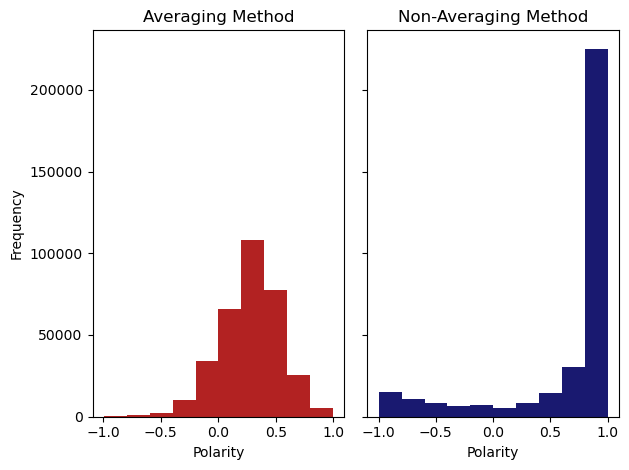

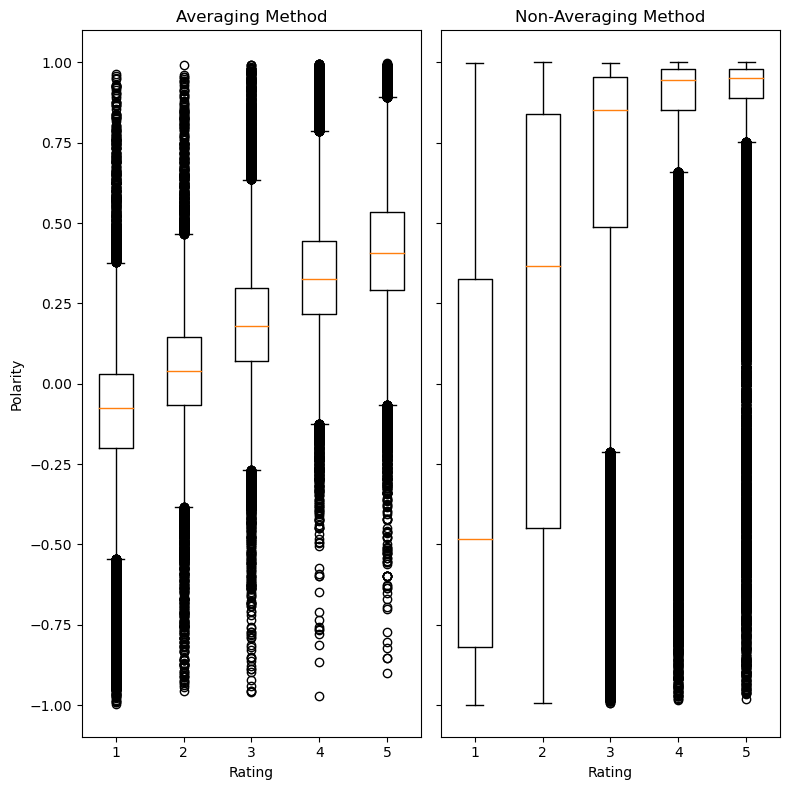

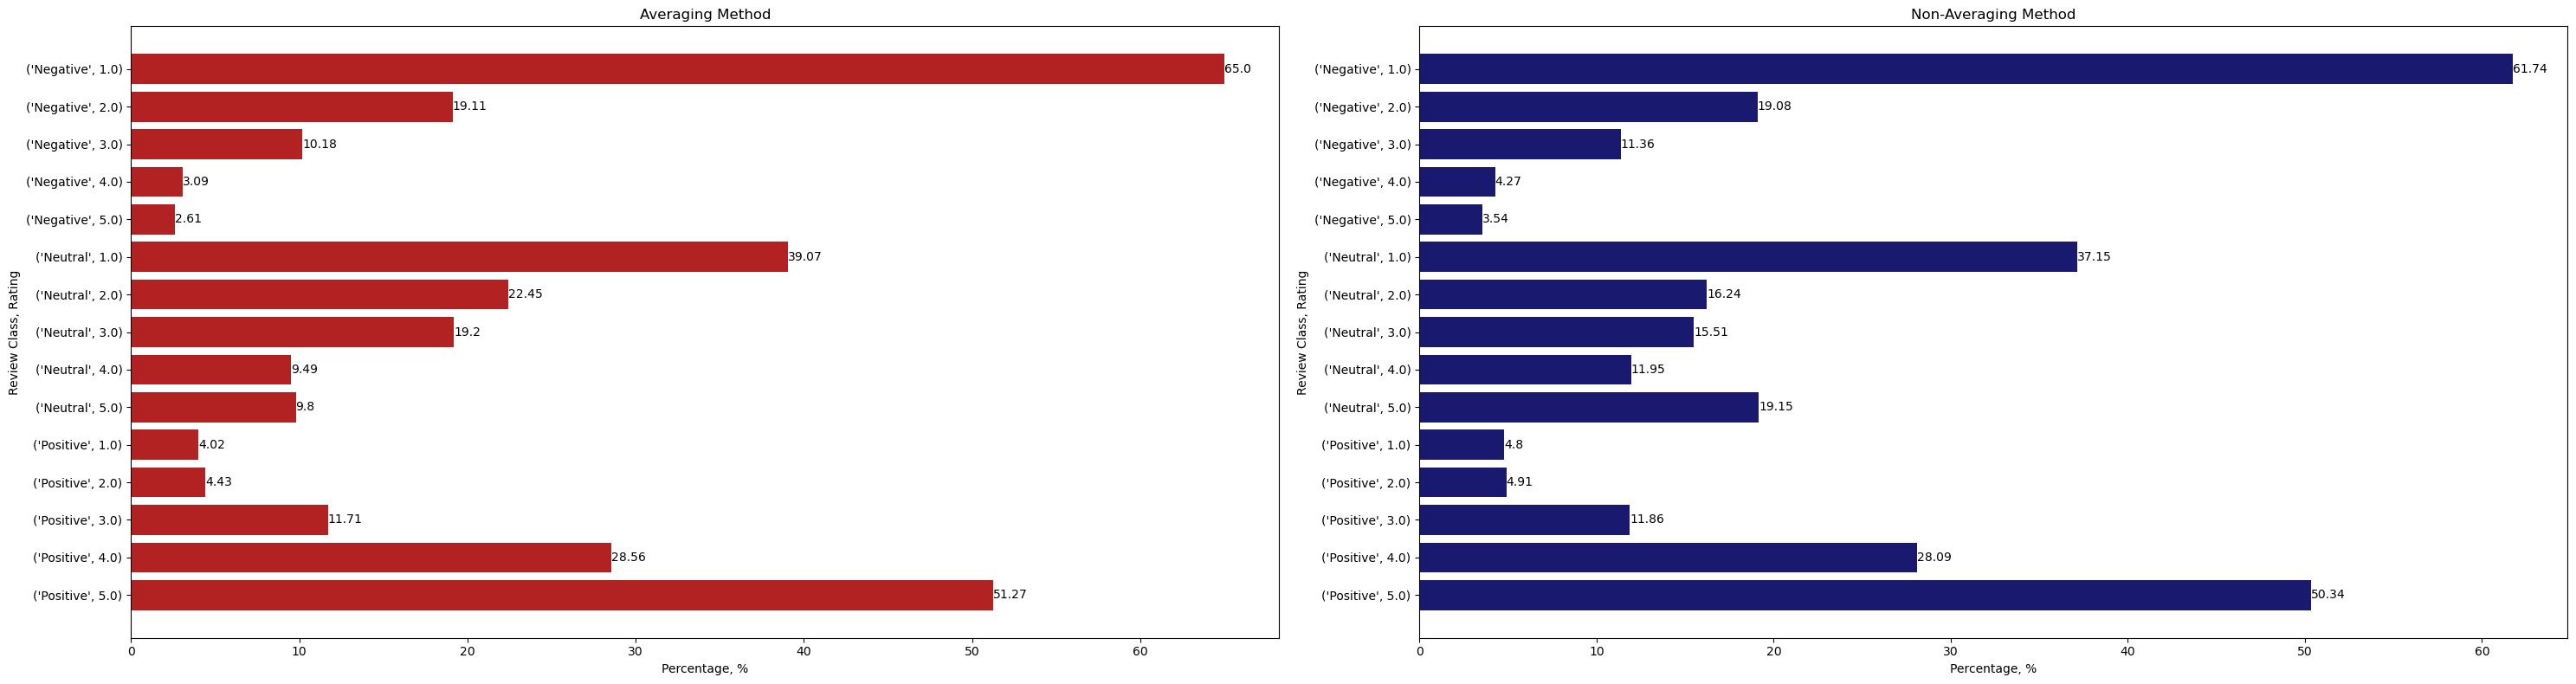

In [78]:
# Compare model choices from VADER
df = analyze_vader(df=df, sentiment=reviews)

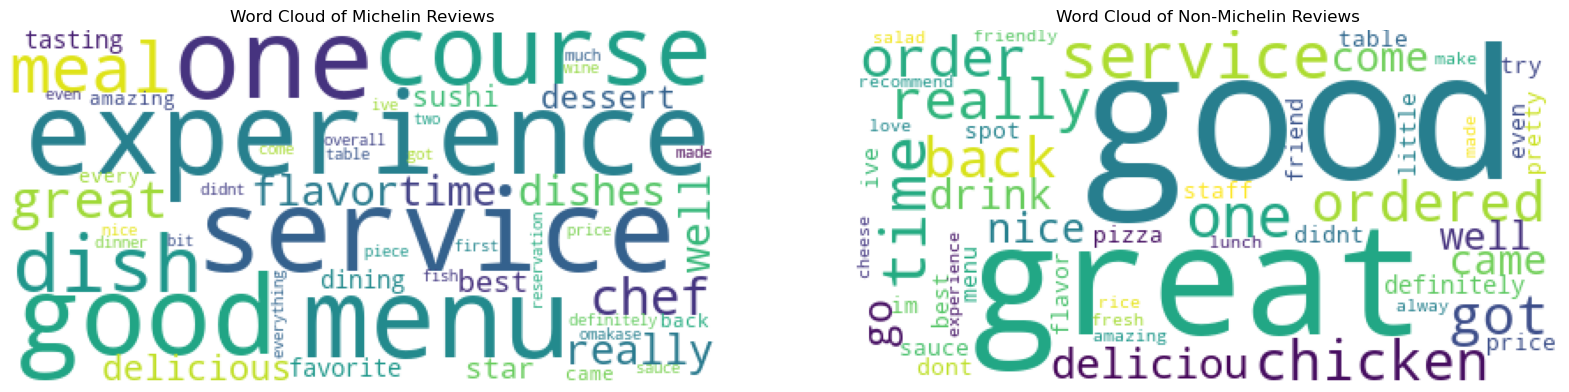

In [79]:
# Generate word clouds on reviews, without sentiment class
generate_word_clouds(df=df, column=column, words=words, to_download=to_download)

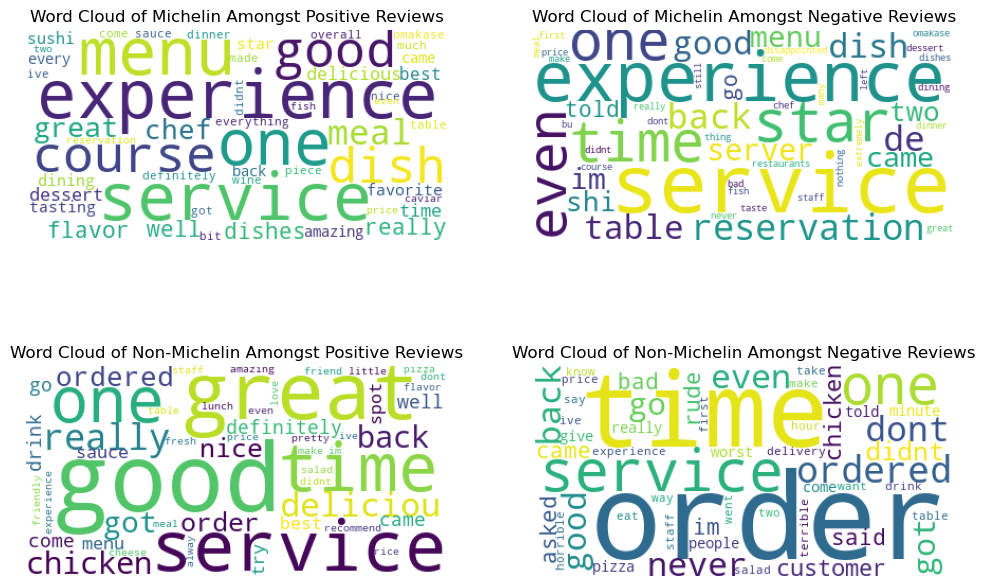

In [80]:
# Generate word clouds on reviews, with sentiment class
generate_word_clouds(df=df, column=column, words=words, sent_class=True, to_download=to_download)

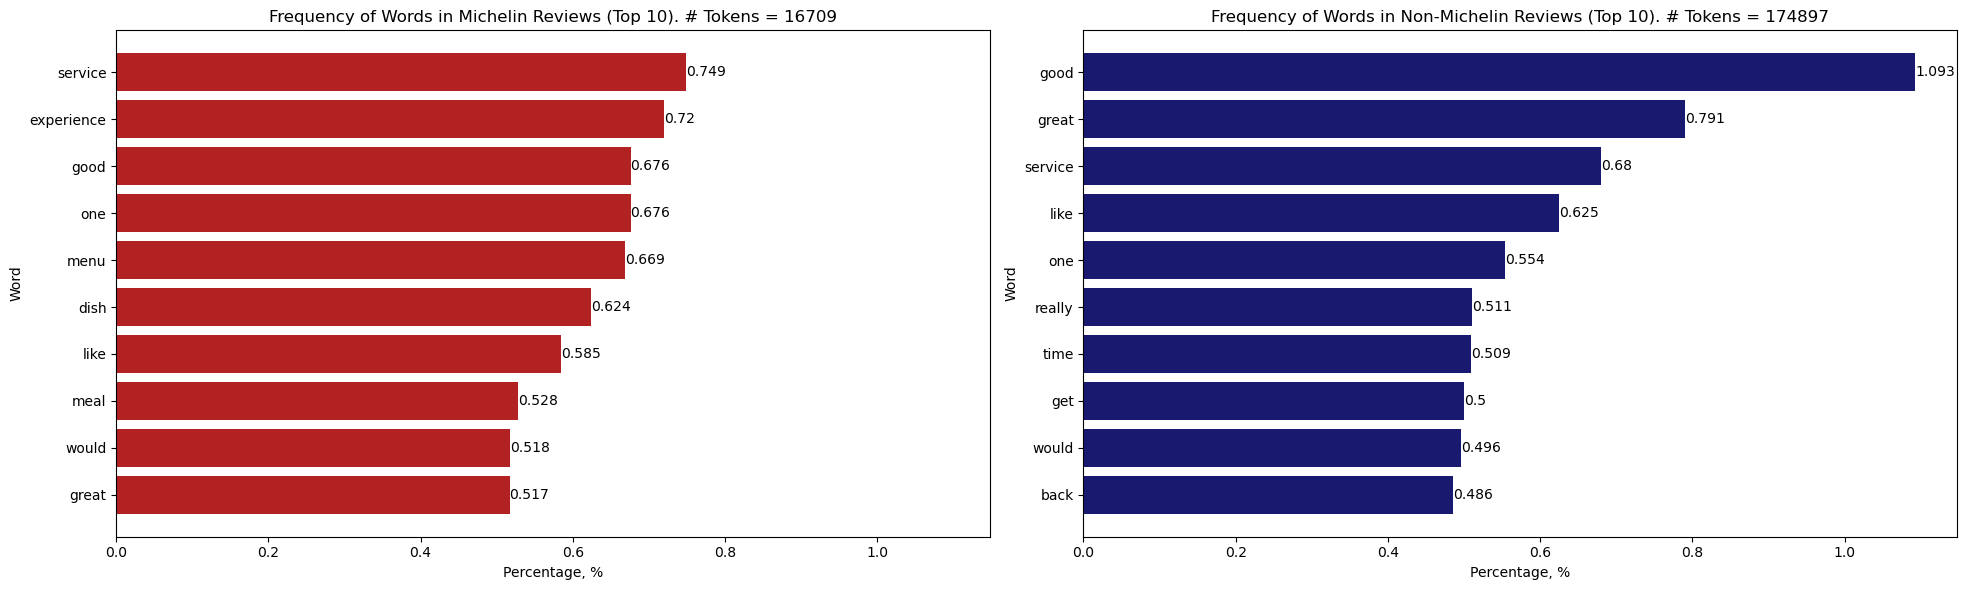

In [81]:
# Generate word frequency plots, without sentiment class
word_freq_plot(process_text(df=df, column=column, words=words, sent_class=False, to_download=to_download), column_name=column)

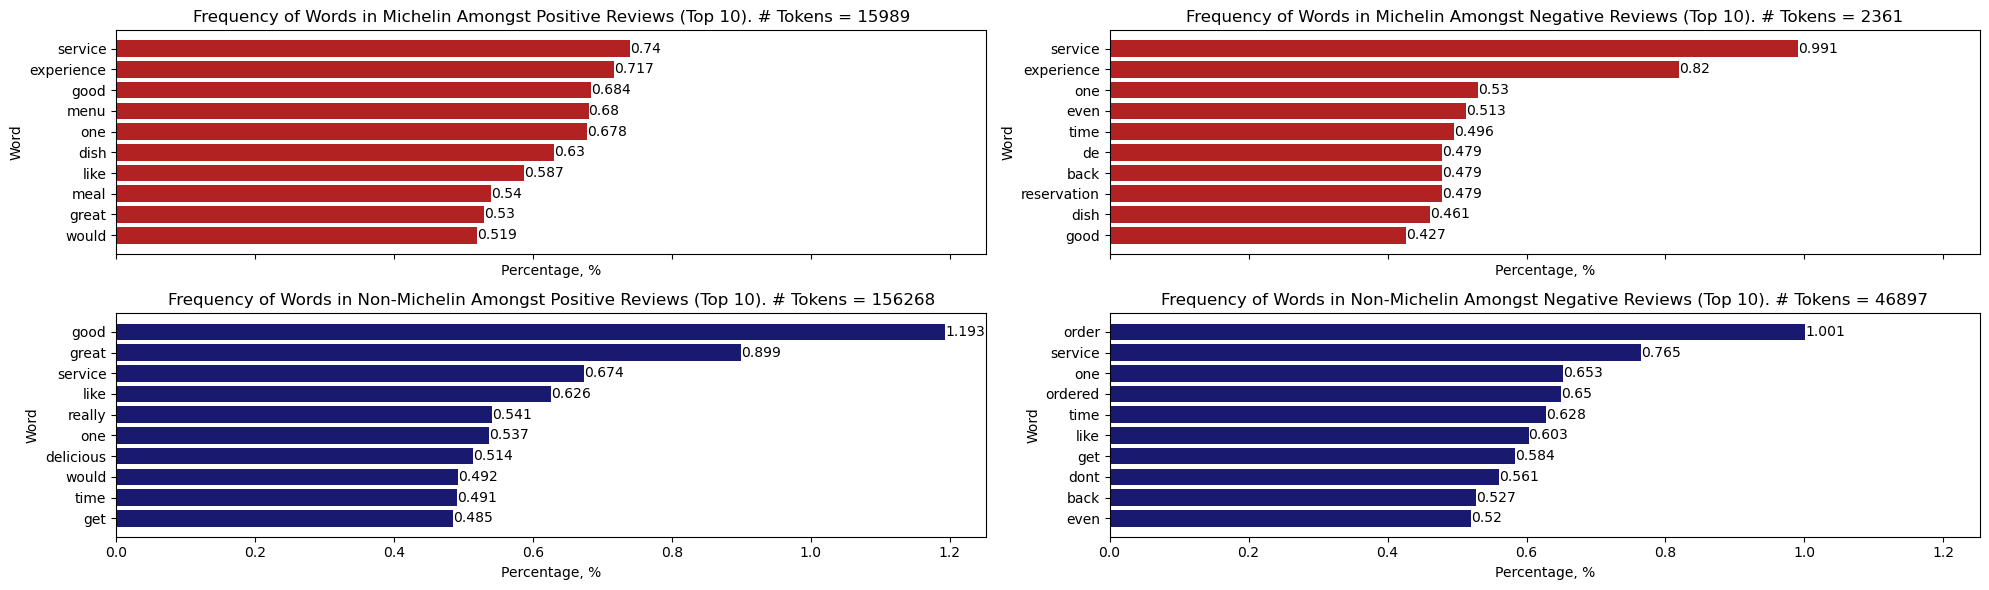

In [82]:
# Generate word frequency plots, with sentiment class
word_freq_plot(process_text(df=df, column=column, words=words, sent_class=True, to_download=to_download), column_name=column)

In [83]:
# Retain significant words for michelin reviews, without sentiment class
mich_sig = word_sig_test(process_text(df=df, column=column, words=words, sent_class=False, to_download=to_download))
mich_sig

,Word,Frequency
0,service,1865
1,experience,1792
3,one,1682
4,menu,1664
5,dish,1553
7,meal,1315
10,course,1197
12,dishes,1102
13,well,1060
15,best,937


In [84]:
# Retain significant words for michelin reviews, with sentiment class
mich_sig_class = word_sig_test(process_text(df=df, column=column, words=words, sent_class=True, to_download=to_download))
mich_sig_class # indication of michelin among positive

,Word,Frequency
0,service,1757
1,experience,1703
3,menu,1615
4,one,1611
5,dish,1497
7,meal,1282
10,course,1160
12,dishes,1054
13,well,1042
15,best,924


In [85]:
# Process n-grams (bigrams)
ng_nc = process_ngrams(process_text(df=df, column=column, words=n_gram_words, sent_class=False, to_download=to_download))
ng_c = process_ngrams(process_text(df=df, column=column, words=n_gram_words, sent_class=True, to_download=to_download))

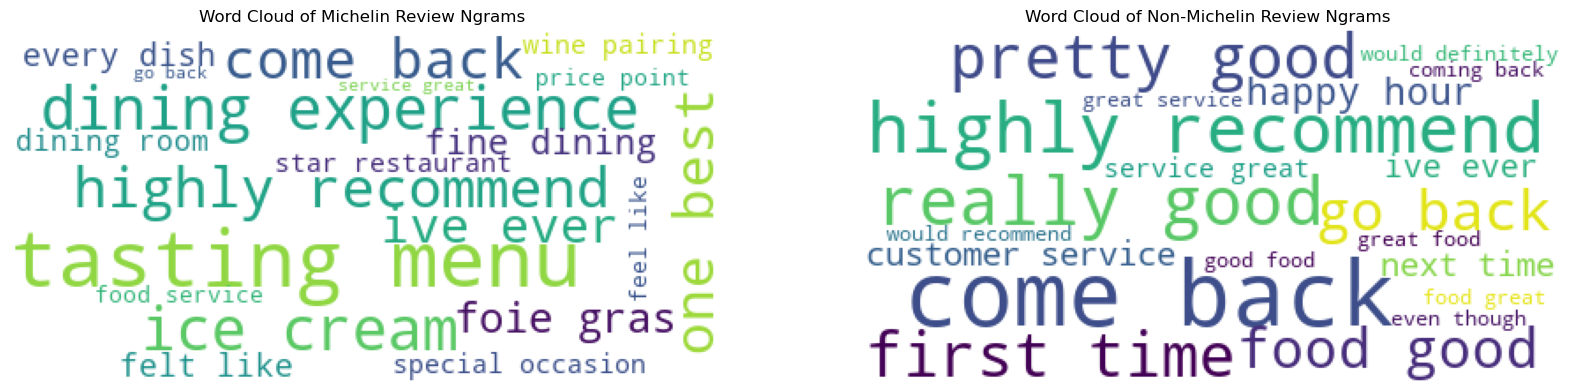

In [86]:
# Generate word clouds of n-grams without sentiment class
generate_word_clouds_ngrams(df=df, column=column, words=n_gram_words, sent_class=False, to_download=to_download)

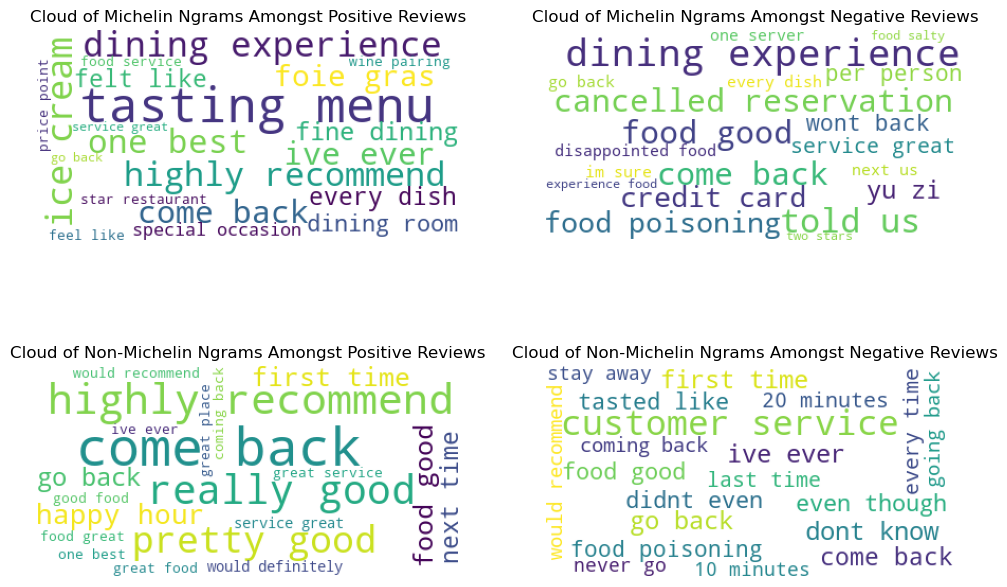

In [87]:
# Generate word clouds of n-grams with sentiment class
generate_word_clouds_ngrams(df=df, column=column, words=n_gram_words, sent_class=True, to_download=to_download)

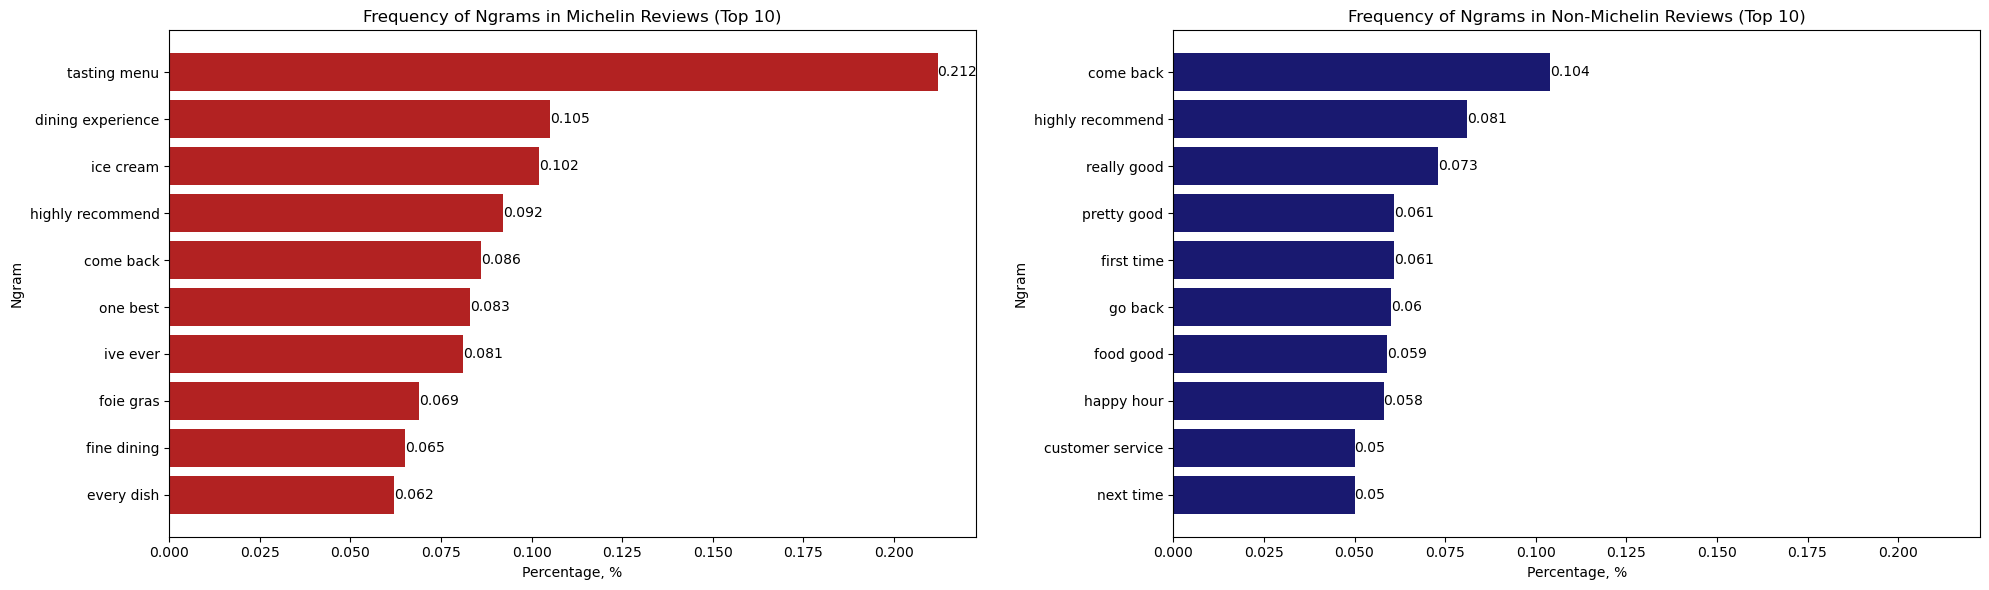

In [88]:
# Generate n-gram frequency plots, without sentiment class
ngram_freq_plot(freq_dfs=ng_nc, column_name=column)

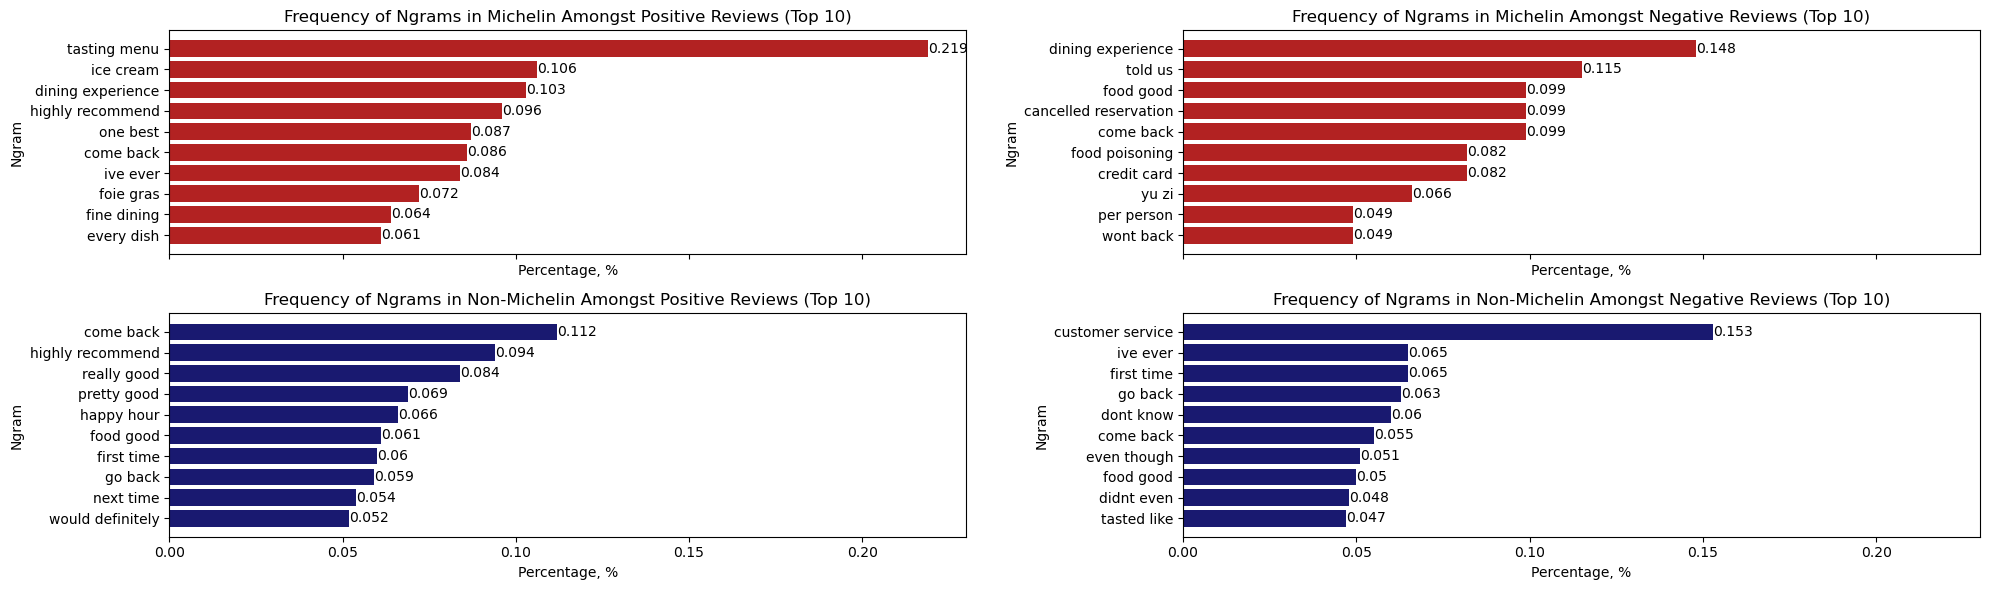

In [89]:
# Generate n-gram frequency plots, with sentiment class
ngram_freq_plot(freq_dfs=ng_c, column_name=column)

In [90]:
# Retain significant n-grams without sentiment class
ng_sig_nc = ngram_sig_test(freq_dfs=ng_nc)
ng_sig_nc

,Ngram,Frequency
0,tasting menu,543
1,dining experience,268
2,ice cream,262
3,highly recommend,235
4,come back,219
5,one best,213
6,ive ever,207
7,foie gras,177
8,fine dining,167
9,every dish,158


In [91]:
# Retain significant n-grams with sentiment class
ng_sig_c = ngram_sig_test(freq_dfs=ng_c)
ng_sig_c # indication of michelin among positive

,Ngram,Frequency
0,tasting menu,534
1,ice cream,260
2,dining experience,252
3,highly recommend,234
4,one best,213
5,come back,210
6,ive ever,205
7,foie gras,175
8,fine dining,156
9,every dish,149
